In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import datetime, timedelta
import pickle
import itertools
import glob

In [3]:
import matplotlib.dates as dates
from scipy import stats
import pingouin as pg
from scipy.stats import variation
import math
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
import itertools

/home/srj34/jupyter-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
import matplotlib.pyplot as plt
#font = {'family': 'serif', 'serif': ['Palatino']}
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [5]:
label_fontsize = 16
title_fontsize = 16

In [6]:
#Set up parameters for figure display
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'axes.labelweight': 'bold',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
pylab.rcParams["font.family"] = "serif"
pylab.rcParams["font.weight"] = "heavy"
#pylab.rcParams.update({'figure.autolayout': True})

In [7]:
sns.set(font_scale=1.25, style="whitegrid")

In [8]:
base_dir = '/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/'
beh_files = 'decAlertnessDecisionmaking_JNeuroscience2021/beh_data/csv_files/'
output_dir = 'decAlertnessDecisionmaking_JNeuroscience2021/Figures/'

In [9]:
beh_file = 'RT_all.csv'
RT_data = pd.read_csv(base_dir+beh_files+beh_file)

In [10]:
RT_data.head()

,subj_idx,RT,state
0,2.0,1.074436,Alert
1,2.0,1.760000,Drowsy
2,4.0,0.723141,Alert
3,4.0,1.015365,Drowsy
4,5.0,0.675023,Alert


In [11]:
stat_data = RT_data.pivot(index='subj_idx', columns='state', values='RT')

In [12]:
stat_data.head()

state,Alert,Drowsy
subj_idx,,
2.0,1.074436,1.760000
4.0,0.723141,1.015365
5.0,0.675023,1.845944
6.0,1.151063,1.769548
7.0,0.862764,0.803564


In [13]:
print('Total subjects: ', len(stat_data))
print('subjects with drowsy RT > alert RT: ', np.sum(stat_data['Drowsy'] > stat_data['Alert']))

Total subjects:  32
subjects with drowsy RT > alert RT:  29


In [14]:
res = pg.ttest(stat_data['Alert'],stat_data['Drowsy'], paired = True, correction='auto')
res

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-7.789098,31,two-sided,8.658997e-09,"[-0.69, -0.4]",1.337998,1.486e+06,1.0


In [15]:
t_stat = res['T'].values[0]
p_val = res['p-val'].values[0]
df_test = res['dof'].values[0]
cohens_d = res['cohen-d'].values[0]

In [16]:
pal = {Condition: "b" if Condition == 'Drowsy' else "r" for Condition in RT_data.state.unique()}

In [17]:
fig_dir = base_dir + output_dir
fig_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decAlertnessDecisionmaking_JNeuroscience2021/Figures/'

In [18]:
def statannotation(ax, x1, x2, y,text):
    h = 0.1
    text_offset = 0.5
    
    line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]

    ax.plot(line_x, line_y, lw=2, c='black')
    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                      xytext=(0, text_offset), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom',
                      fontsize=label_fontsize-2, clip_on=False, annotation_clip=False)

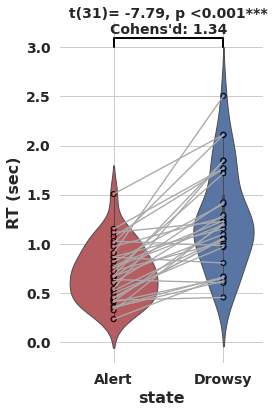

In [19]:
f, (ax1) = plt.subplots(ncols=1, sharex=True,figsize=(4, 6))

ax2 = sns.pointplot(x="state",y="RT",hue='subj_idx',data=RT_data, ax=ax1, dodge=0.0, scale = 0.5, 
                    markers = '', palette=['darkgray'])

ax2.legend_.remove()

ax3 = sns.violinplot(x="state",y="RT",data=RT_data, dodge=True, linewidth=1, ax = ax1, palette = pal)

ax4 = sns.stripplot(x="state",y="RT",data=RT_data, jitter=False, linewidth=1, ax=ax1,edgecolor ="black",
                     palette=pal)


string_val = 't(' + str(np.round(df_test,2)) + ')= ' + str(np.round(t_stat,2)) + ', p' + ' <0.001***'+ \
              "\nCohens'd: " + str(np.round(cohens_d,2))

# ax1.text(-0.4, 2.75, string_val, va='center', fontweight='bold',rotation='horizontal', fontsize=label_fontsize-2)

statannotation(ax = ax1, x1 = 0, x2 = 1, y = 3.0, text = string_val)

plt.setp(ax1.collections, alpha=1)

sns.despine(left=True, bottom = True)

plt.ylabel('RT (sec)', fontsize=label_fontsize, weight = 'bold')
plt.xlabel('state', fontsize=label_fontsize, weight = 'bold')
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
plt.tight_layout()
plt.box(False)
plt.grid(True)
plt.savefig(fig_dir + "RT_variability" + ".png", format='png', dpi=240, transparent=False)